# Description

Goals of the notebook:
- Generate a high dimensional dataset using sklearn
- Use the algorithm to learn representations on that
- Testing KSM without tracking any variable

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import os
import json
import numpy as np
import torch
import hydra
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm, trange
from src.plot_utils import scatter_plot_2d
from src.utils import sparsity_measure
from omegaconf import OmegaConf
from torchvision.utils import make_grid
from pprint import pprint
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from datetime import datetime
from sklearn.decomposition import MiniBatchDictionaryLearning, SparseCoder, DictionaryLearning
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

In [50]:
sns.set_style('ticks')
sns.set_context("paper", font_scale=1.0, rc={"text.usetex": True})
sns.set_palette("colorblind")
sns.set_style({"font.family": "serif", "font.serif": ["Times New Roman"]})

In [51]:
project_dir = Path('/n/home13/shubham/Current Projects/bioplausible_learning/code')

In [52]:
with hydra.initialize(version_base=None, config_path="../../../configs"):
    cfg = hydra.compose(config_name='ksm_high_dim.yaml')
    exp_params = OmegaConf.to_container(cfg, resolve=True)
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

exp_params['device'] = 'device'

# figfolder = Path(f'../../results/simulated/highdim/{datetime.now().strftime("%m-%d")}/{datetime.now().strftime("%H-%M")}')
# os.makedirs(figfolder, exist_ok=True)    
pprint(exp_params)    

{'dataset': {'batch_size': 128,
             'dim': 30,
             'n_samples': 1500,
             'name': 'highdim'},
 'device': 'device',
 'model': {'K': 16,
           'Winit': 'Kmeans',
           'lam': 0.5,
           'omega': 0.0001,
           'perturbation': 0.1,
           'rho': 1.0,
           'sparsity': 0.125},
 'optimizer': {'Minit': 'zero',
               'latent_iters': 15,
               'log_interval': 10,
               'lrs': {'Z': 0.01,
                       'Z_decay': 0.9,
                       'interval': 10,
                       'params': 0.01},
               'max_epochs': 3000,
               'param_iters': 1,
               'vis_interval': 20}}


Simulated data generated from a tall dictionary

In [53]:
from sklearn.datasets import make_sparse_coded_signal

def get_sim_data(n_samples, n_components, n_features, n_nonzero_coefs, max_correlation=0.3, noise=None, seed=42):
    
    np.random.seed(seed)
    positions = np.random.randint(0, high=n_components, size=(n_samples, n_nonzero_coefs))
    vals = 5 + (-1)*np.random.rand(n_samples, n_nonzero_coefs)
    Z = np.zeros((n_samples, n_components))
    Z[np.arange(n_samples)[:, None], positions] = vals
    
    # Create D with max correlation
    # random_matrix = 2*(max_correlation) * np.random.rand(n_components, n_components) - max_correlation
    # lower_triangle = np.tril(random_matrix, k=0)
    # print(lower_triangle)
    # cov = lower_triangle @ lower_triangle.T + np.eye(n_components)
                                   
    # cov = random_matrix + random_matrix.T
    
    cov = np.eye(n_components)
    # np.fill_diagonal(cov, 1)
    
    D = np.random.multivariate_normal(np.zeros(n_components), cov, size=n_features).T
    # print(np.linalg.norm(D, axis=1, keepdims=True))
    D /= np.linalg.norm(D, axis=1, keepdims=True)
    X = Z @ D
    
    
    
    # X, D, Z = make_sparse_coded_signal(n_samples=n_samples, n_components=n_components, n_features=n_features, n_nonzero_coefs=n_nonzero_coefs, random_state=seed)
    
    if noise is not None:
        # Adding Gaussian Noise
        X += noise * np.random.randn(*X.shape)    
    
    return torch.from_numpy(X).float(), torch.from_numpy(D).float(), torch.from_numpy(Z).float()


X, D, Z = get_sim_data(n_samples=exp_params['dataset']['n_samples'],
                       n_components=exp_params['model']['K'],
                       n_features=exp_params['dataset']['dim'],
                       n_nonzero_coefs=np.ceil(exp_params['model']['K']*exp_params['model']['sparsity']).astype(int),
                       seed=42)

# Create pytorch dataset and dataloader
indices = torch.arange(X.shape[0])
dataset = TensorDataset(X, indices)
dataloader = DataLoader(dataset, batch_size=exp_params['dataset']['batch_size'], )

In [ ]:
# Visualize dictionary D with colorbar
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
im = ax.imshow(D.T, aspect='auto')
ax.set_title(f'Dictionary D ({D.shape[1]}x{D.shape[0]})')
ax.grid(False)
fig.colorbar(im, ax=ax, orientation='vertical')
plt.show()

In [55]:
print("Max correlation between columns")
print(f"Max: {torch.max(torch.abs(D @ D.T - torch.eye(D.shape[0]))):.2f}")

Max correlation between columns
Max: 0.48


In [ ]:
# Compute Cluster centers for the given data
kmeans = KMeans(n_clusters=exp_params['model']['K'], random_state=42).fit(X)
W_init = kmeans.cluster_centers_
W_init /= np.linalg.norm(W_init, axis=1, keepdims=True)

# sim_lam = 2*exp_params['model']['lam']
# print(sim_lam)
coder = SparseCoder(dictionary=W_init, transform_alpha=exp_params['model']['lam'], transform_algorithm='lasso_lars')
init_codes = coder.transform(X.numpy())

#### Loading learnt values from sklearn dictionary learning

In [57]:
filename = f"learnt_normal_dict_K{exp_params['model']['K']}_lam{0.1:.2e}_n{exp_params['dataset']['dim']}.pkl"
folder = project_dir / 'data/simulated/'
with open(folder / filename, 'rb') as f:
    data = pickle.load(f)
    synthetic_dict = data['obj']
    Z = data['Z']
    X = data['X']

In [58]:
def compute_reconstruction_error(X, D, Z):
    """
    Compute the reconstruction error of the given data
    X: (n_samples, n_features)
    D: (n_components, n_features)
    Z: (n_samples, n_components)
    """
    prediction = Z @ D
    error = np.mean(np.linalg.norm(X - prediction, axis=1)**2)
    return error

In [59]:
# Print the r2 score
Z_est = synthetic_dict.transform(X)
r2 = r2_score(X, Z_est @ synthetic_dict.components_)
print(f"R2 Score: {r2:0.4f}")

# Calculate sparsity level
# sparsity = np.mean(np.sum(Z_est != 0, axis=1)) / exp_params['model']['K']
sparsity = sparsity_measure(torch.from_numpy(Z_est))
print(f"Sparsity level: {sparsity:0.2f}")

synthetic_dict_output ={
    'D': torch.from_numpy(synthetic_dict.components_).float(),
    'Z': torch.from_numpy(Z_est).float(),
}

R2 Score: 0.9994
Sparsity level: 0.86


In [60]:
from src.visualizations import visualize_latents
from src.utils import realign_dictionaries

[ 9  1  0 13  2 12  8  3 15  4  7  5  6 10 11 14]


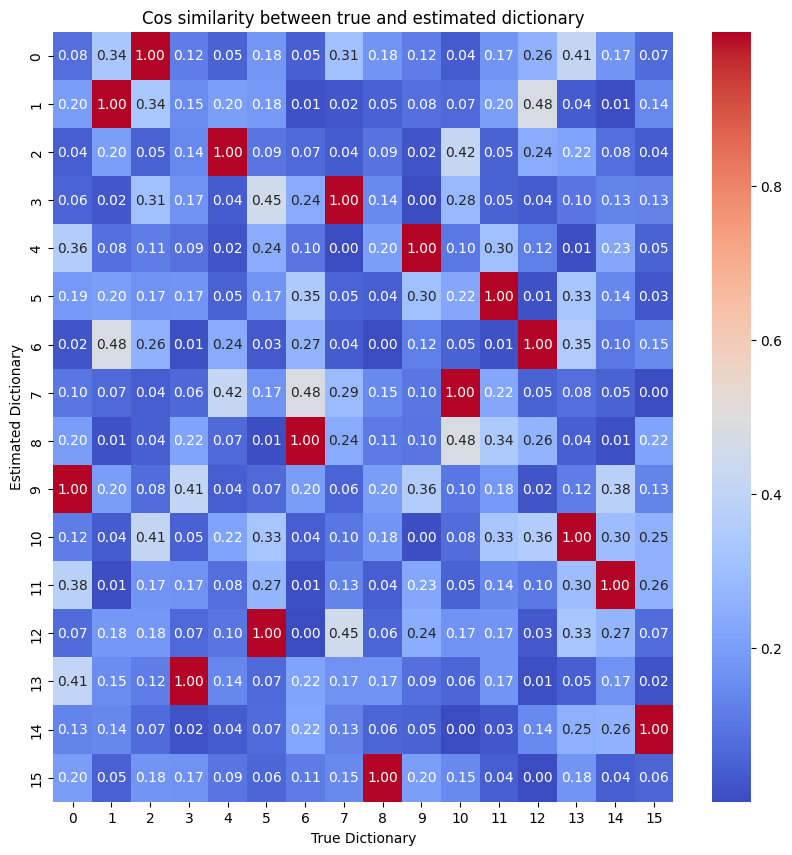

In [13]:
# Align dictionaries
cos_sim = np.abs(synthetic_dict.components_ @ D.numpy().T)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(cos_sim, ax=ax, cmap='coolwarm', annot=True, fmt='.2f')
ax.set_title('Cos similarity between true and estimated dictionary')
ax.set_xlabel('True Dictionary')
ax.set_ylabel('Estimated Dictionary')
fig.show()

positions = realign_dictionaries(cos_sim)
print(positions)

### Run gradient dynamics of KSM

In [71]:
from src.models import KSM_objective

In [72]:
def initializeTensors(exp_params, n_samples, Zinit=None, Pinit=None, Minit=None, seed=42, device='cpu'):
    torch.manual_seed(seed)
    if Zinit is None:
        Z = torch.randn(size=(n_samples, exp_params['model']['K']), dtype=torch.float32, requires_grad=False)
    else:
        Z = Zinit.clone()
        
        
    if Pinit is None:    
        Z_t = Z.unsqueeze(-1)
        V = Z_t @ Z_t.transpose(-1, -2)
        P = V + exp_params['model']['omega'] * torch.eye(exp_params['model']['K'], dtype=torch.float32, requires_grad=False, device=device)
    else:
        P = Pinit.clone()
        
        
    if Minit is None:        
        M_t = torch.randn(size=P.shape, requires_grad=False, dtype=torch.float32)
        M = M_t @ M_t.transpose(-1, -2)
        M = M / torch.linalg.norm(M, dim=(1, 2), keepdims=True)
    else:
        M = Minit.clone()
        
        
    # print("Initialized M")
    
    variables = {'Z': Z, 'P': P}
    lagrange = {'M': M}
    
    return variables, lagrange

In [79]:
# Create results folder
current_path = Path.cwd()
results_folder = current_path / 'results'/f'{datetime.now().strftime("%m-%d")}/Notrack/'
os.makedirs(results_folder, exist_ok=True)
from copy import deepcopy
cfg = deepcopy(exp_params)

# folder = project_dir / f'results/simulated/highdim/{datetime.now().strftime("%m-%d")}/{datetime.now().strftime("%H-%M")}'
os.makedirs(results_folder, exist_ok=True)
cfg.pop('device')
cfg = OmegaConf.create(cfg)
with open(results_folder / 'config.yaml', 'w') as f:
    OmegaConf.save(cfg, f)

In [80]:
exp_params['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = exp_params['device']
# M_init = torch.zeros(size=(exp_params['dataset']['n_samples'], exp_params['model']['K'], exp_params['model']['K']), dtype=torch.float32, requires_grad=False).to(device)
W = torch.from_numpy(W_init).float()
M_init = W @ W.T / 2


In [81]:
from src.optimizers import optimizationADMM_proximal_notrack

In [82]:
M_init =  M_init.repeat(exp_params['dataset']['n_samples'], 1, 1).to(device)
Z_init = torch.from_numpy(init_codes).float().to(device)
variables, lagrange = initializeTensors(exp_params, n_samples=exp_params['dataset']['n_samples'], Zinit=Z_init, Minit=M_init, seed=42, device=device)
exp_params['optimizer']['max_epochs'] = 3500
exp_params['optimizer']['latent_iters'] = 15
exp_params['optimizer']['log_interval'] = 10
exp_params['optimizer']['lrs']['params'] = 1e-2
exp_params['optimizer']['param_iters'] = 1
exp_params['model']['lam'] = 0.5
model = KSM_objective(exp_params, W_init=torch.from_numpy(W_init).float())
optimizer = optimizationADMM_proximal_notrack(exp_params, model, eta=0.05)


In [84]:
from src.admms import run_ADMM_notrack

In [85]:
true_vals = {'D': D, 'Z': Z}

loss_vals = run_ADMM_notrack(model, optimizer, X, variables, lagrange, dataloader, exp_params, 
                    true_vals=synthetic_dict_output, device=device, update_eta=True, normW=True)


Training: 100%|██████████| 3500/3500 [09:09<00:00,  6.37it/s, Total Loss: -16.3583 | Similarity Loss: -20.3148 | L1 Loss: 0.9192 | Penalty: 0.0000 | R2_W: 0.9847 | R2_est: 0.9992 | D_sim: 0.9298 | Z_sim: 0.8379 | DW_sim: 0.9297 | new_eta: 0.3952]


In [ ]:
# Let's plot the losses
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# exp_params['optimizer']['max_epochs'] = len(loss_vals['total_loss']) * exp_params['optimizer']['log_interval']
iterations = np.arange(0, exp_params['optimizer']['max_epochs'], step=exp_params['optimizer']['log_interval'])
ax = axs[0]
ax.plot(iterations[1:], loss_vals['total_loss'][1:])
ax.set_title('Total Loss')
# ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

ax = axs[1]
ax.plot(iterations[1:], loss_vals['similarity_loss'][1:])
ax.set_title('Similarity Loss')
# ax.set_xscale('log')
ax.set_xlabel('Iterations')

ax = axs[2]
ax.plot(iterations, loss_vals['sparsity'])
ax.set_title('Sparsity Measure')
# ax.set_xscale('log')
ax.set_xlabel('Iterations')

ax = axs[3]
ax.plot(iterations, loss_vals['penalty'])
ax.set_title('Penalty')
# ax.set_xscale('log')
ax.set_xlabel('Iterations')

fig.savefig(results_folder / 'loss_curves.pdf', format='pdf', bbox_inches='tight')


# ax.plot(loss_vals['loss_Z'])


# Plot the r2 score and similarity measures
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax = axs[0]
# ax.plot(iterations[1:], loss_vals['r2_W'][1:], label=r'$R^2 (W)$')
ax.plot(iterations[1:], loss_vals['r2_est'][1:], label=r'$R^2$ (Estimated)')
# ax.set_xscale('log')
ax.set_title('R2 Score')
ax.set_xlabel('Iterations')
ax.set_ylabel('R2 Score')
ax.legend()

ax = axs[1]
# ax.plot(iterations, loss_vals['dw_sim'], label='cos sim (W)')
ax.plot(iterations, loss_vals['dest_sim'], label='cos sim (est)')
# ax.set_xscale('log')
ax.set_title('Cos Similarity for estimated dictionary')
ax.set_xlabel('Iterations')
ax.set_ylabel('Value')
ax.legend()

ax = axs[2]
ax.plot(iterations, loss_vals['latent_sim'])
# ax.set_xscale('log')
ax.set_title('Cos Similarity for latent codes')
ax.set_xlabel('Iterations')
ax.set_ylabel('Value')

fig.savefig(results_folder / 'r2_n_cossim.pdf', format='pdf', bbox_inches='tight')

fig.show()


In [ ]:
# Plot dictionaries side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
D_W = model.W.cpu().numpy()
H_est = torch.mean(variables['P'], dim=0)
Z_est = variables['Z']
D_est = torch.linalg.solve(H_est, Z_est.T).cpu() @ X / X.shape[0]
D_est = D_est.numpy()

ax = axs[0]
im = ax.imshow(true_vals['D'].T, aspect='auto')
ax.set_title('True Dictionary')
ax.grid(False)
fig.colorbar(im, ax=ax, orientation='vertical')

ax = axs[1]
im = ax.imshow(D_W.T, aspect='auto')
ax.grid(False)
ax.set_title(r'$W^T$')
fig.colorbar(im, ax=ax, orientation='vertical')

ax = axs[2]
im = ax.imshow(D_est.T, aspect='auto')
ax.grid(False)
ax.set_title('Estimated Dictionary')
fig.colorbar(im, ax=ax, orientation='vertical')



In [ ]:
# Align dictionaries
D_W = model.W.cpu().numpy()
D_W_norm = D_W / np.linalg.norm(D_W, axis=1, keepdims=True)
H_est_ksm = torch.mean(variables['P'], dim=0)
Z_est_ksm = variables['Z']
D_est_ksm = torch.linalg.solve(H_est_ksm, Z_est_ksm.T).cpu() @ X / X.shape[0]
D_est_ksm = D_est_ksm.numpy()
D_est_ksm_norm = D_est_ksm / np.linalg.norm(D_est_ksm, axis=1, keepdims=True)
cos_sim_ksm = np.abs(D_est_ksm_norm @ D.numpy().T)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(cos_sim_ksm, ax=ax, cmap='coolwarm', annot=True, fmt='.2f')
ax.set_title('Cos similarity between true and estimated dictionary')
ax.set_xlabel('True Dictionary')
ax.set_ylabel('Estimated Dictionary')
fig.show()



In [26]:
from src.utils import realign_dictionaries

In [27]:
positions_ksm = realign_dictionaries(cos_sim_ksm)
print(positions_ksm)


[ 9  1  0 13  2 12 14  3 15  4  8  5  6 10 11  7]


In [ ]:
# Plot the dictionary
D_est_realigned_ksm = D_est_ksm_norm[positions_ksm]
W_init_realigned_ksm = W_init[positions_ksm]
n_rows = 4
n_cols = D.shape[0] // n_rows
fig, ax = plt.subplots(n_rows, D.shape[0] // n_cols, figsize=(4*n_cols, 4*n_rows))
ax = ax.ravel()
for i in range(D.shape[0]):
    ax[i].plot(np.abs(D_est_realigned_ksm[i]), label='Estimated', c='g', linestyle='-', marker='x')
    ax[i].plot(np.abs(D[i]), label='True', c='r', linestyle='--', marker='o', alpha=0.9)
    ax[i].plot(np.abs(W_init_realigned_ksm[i]), label='Initial', c='b', linestyle='-.', marker='s', alpha=0.3)
    # ax[i].plot(D[i], label='True')
    # ax[i].plot(W_init_realigned[i], label='KMeans')
    ax[i].set_title(f'Component {i}')
ax[0].legend()
fig.suptitle('Dictionary Components from KSM')
fig.tight_layout()
fig.savefig(results_folder / 'dictionary_components_ksm.pdf', format='pdf', bbox_inches='tight')
fig.show()

In [ ]:
# Plot the dictionary
D_est_realigned_ksm = D_est_ksm[positions_ksm]
W_init_realigned_ksm = W_init[positions_ksm]
n_rows = 4
n_cols = D.shape[0] // n_rows
fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
ax = ax.ravel()
for i in range(D.shape[0]):
    ax[i].plot(np.abs(D_est_realigned_ksm[i]), label='Estimated', c='g', linestyle='-', marker='x')
    ax[i].plot(np.abs(D[i]), label='True', c='r', linestyle='--', marker='o', alpha=0.9)
    ax[i].plot(np.abs(W_init_realigned_ksm[i]), label='Initial', c='b', linestyle='-.', marker='s', alpha=0.3)
    # ax[i].plot(D[i], label='True')
    # ax[i].plot(W_init_realigned[i], label='KMeans')
    ax[i].set_title(f'Component {i}')
ax[0].legend()
fig.suptitle('Dictionary Components from KSM')
fig.tight_layout()
fig.savefig(results_folder / 'dictionary_components_ksm_notnormalized.pdf', format='pdf', bbox_inches='tight')
fig.show()

In [87]:
# Save the model
filename = f"ksm_K{exp_params['model']['K']}_lam{exp_params['model']['lam']:.2e}_n{exp_params['dataset']['dim']}_epochs{exp_params['optimizer']['max_epochs']}.pkl"
with open(results_folder / filename, 'wb') as f:
    save_data = {'model': model, 
                 'variables': variables, 
                 'lagrange': lagrange, 
                 'loss_vals': loss_vals, 
                 'true_vals': true_vals, 
                 'X': X}
    pickle.dump(save_data, f)

In [ ]:
# Visualize latents
from src.visualizations import visualize_latents
true_Z = Z.numpy()
Z_est_ksm = variables['Z'].cpu().detach().numpy()
# Z_init = Z_init.cpu().numpy()
fig, ax = plt.subplots(5, 1, figsize=(4, 10))
ax = visualize_latents(true_Z, ax=ax, seed=42, linefmt='r--', markerfmt='ro', basefmt='r--', label='True')
ax = visualize_latents(Z_init[:, positions_ksm], ax=ax, seed=42, linefmt='b-.', markerfmt='bs', basefmt='b-.', label='Initial')
ax = visualize_latents(Z_est_ksm[:, positions_ksm], ax=ax, seed=42, linefmt='g-', markerfmt='gx', basefmt='g-', label='Estimated')

ax[0].legend()
fig.tight_layout()
fig.savefig(results_folder / 'estimated_latents.pdf', format='pdf', bbox_inches='tight')
fig.show()
